In [5]:
# !brew install libomp
# !pip install "u8darts[all]"

In [11]:
!pip install darts
# !pip install torch

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

Exception: Could not deserialize ATN with version  (expected 4).

<Axes: xlabel='Date'>

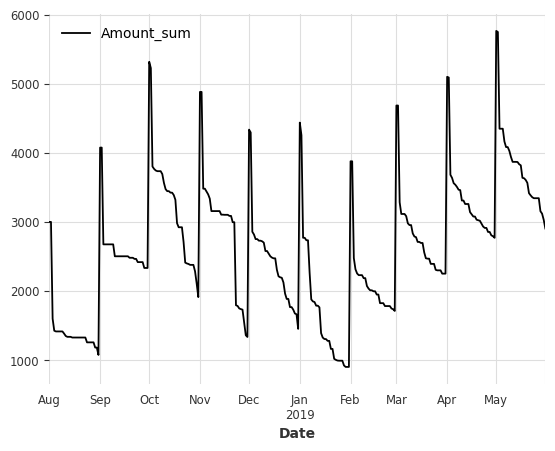

In [3]:
expenses = pd.read_csv("Expenses Data Set.csv")
from datetime import datetime

def parse_date(date):
    list_date = date.split('/')
    parsed_date = []
    for i in range(len(list_date)):
        if i < 2:
            if len(list_date[i]) == 1:
                parsed_date.append('0' + list_date[i])
            else:
                parsed_date.append(list_date[i])
        else:
            parsed_date.append("20" + list_date[i])
    return '/'.join(parsed_date)

#expenses['Posting Date'] = expenses["Posting Date"].apply(lambda x: '/'.join(['0' + i if x.split('/').index(i) < 2 and len(x.split('/')[x.split('/').index(i)]) == 1 else '20'+i for i in x.split('/')]))
expenses['Posting Date'] = expenses['Posting Date'].apply(parse_date)

date_format = "%m/%d/%Y"
expenses['Posting Date'] = pd.to_datetime(expenses['Posting Date'], format=date_format)

expenses = expenses.rename(columns={'Posting Date':'Date', 'Net worth':'Amount'})
expenses = expenses.drop('Source', axis=1)
expenses = expenses.loc[expenses['Category'] != 'Tuition']
expenses = expenses.reset_index().drop('index', axis=1)
expenses = expenses.loc[expenses['Amount']<0]
expenses = expenses.loc[expenses['Description']!='Rent']
income_df = pd.DataFrame({'Date': pd.date_range(start='2018-08-01', end="2019-09-01", freq='MS'),
                          'Amount': 3000,
                          'Category': 'Wire Transfer',
                          'Description': 'Income'})
rent_df = pd.DataFrame({'Date': pd.date_range(start='2018-08-01', end="2019-09-01", freq='MS') + pd.DateOffset(days=2),
                          'Amount': -1400,
                          'Category': 'Bills',
                          'Description': 'Rent'})
expenses = pd.concat([expenses, income_df], ignore_index=True)
expenses = pd.concat([expenses, rent_df], ignore_index=True)
for date in pd.date_range(start="2018-08-01", end="2019-09-30", freq='D'):
  if date not in expenses['Date'].unique():
    new_row = pd.DataFrame({
        'Date':date,
        'Amount': 0,
        'Category': 'Nothing'
    }, index=[0,1])
    expenses = pd.concat([expenses, new_row], ignore_index=True)
expenses = expenses.sort_values('Date')
expenses = expenses.reset_index(drop=True)
expenses['Amount_sum'] = expenses['Amount'].cumsum(axis=0)
expenses['Month'] = expenses['Date'].dt.month
expenses['Day'] = expenses['Date'].dt.day
expenses['Year'] = expenses['Date'].dt.year
expenses['is_month_start'] = np.where(expenses['Day'] == 1, True, False)


#Define df_indexed
df_indexed = expenses.groupby('Date').sum()
df_indexed = df_indexed.reset_index()
# for date in pd.date_range(start='2018-08-01', end='2019-09-30', freq='D'):
#   if date not in df_indexed['Date'].values:
#     new_row = pd.DataFrame({
#         'Date': date,
#         'Amount': 0
#     }, index=[0,1])
#     df_indexed = pd.concat([df_indexed, new_row], ignore_index=True)

df_indexed['Amount_sum'] = df_indexed['Amount'].cumsum(axis=0)
df_indexed['Month'] = df_indexed['Date'].dt.month
df_indexed['Day'] = df_indexed['Date'].dt.day
df_indexed['Year'] = df_indexed['Date'].dt.year
df_indexed['is_month_start'] = np.where(df_indexed['Day'] == 1, True, False)
df_indexed = df_indexed.sort_values('Date').set_index('Date')
df_indexed = df_indexed.loc[df_indexed.index<'2019-06-01']
df_indexed[['Amount_sum']].plot()

In [7]:
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
FC_N = 62              # forecast periods
FC_STRIDE = 10
FC_START = "2019-04-01"   # period at which to split training and validation dataset
#FC_START = '1959-01-01'
EPOCH = 300

#ts1 = AirPassengersDataset().load()
ts = TimeSeries.from_dataframe(df_indexed[['Amount_sum']].reset_index(),time_col='Date',value_cols= 'Amount_sum')
series = ts
df = ts.pd_dataframe()
#xa = df_indexed[['Amount_sum']].to_xarray()

## load data


series = ts  
df = ts.pd_dataframe()

#ts = TimeSeries.from_dataframe(df_indexed[['Amount_sum']].reset_index(),time_col='Date',value_cols= 'Amount_sum')
train, val = ts.split_after(pd.Timestamp(FC_START))

# analyze its seasonality
is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]


is seasonal? : True
periodicity (months) : 31.0
periodicity (~years) : 2.6


In [8]:
#Scale

trf = Scaler()

#fit the tranform model
train_trf = trf.fit_transform(train)

# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

# create day and month covariate series

month_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000), 
    one_hot=False)
month_series = Scaler().fit_transform(month_series)

day_series = datetime_attribute_timeseries(
    month_series, 
    one_hot=True)

covariates = month_series.stack(day_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy



beginning the training of the LSTM RNN:


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

training of the LSTM RNN has completed: 119.97 sec


Predicting: 0it [00:00, ?it/s]

LSTM : 
MAPE : 4.9717
RMSPE : 0.0647
RMSE : 0.0345
-R squared : -0.9446
se : 0.1837


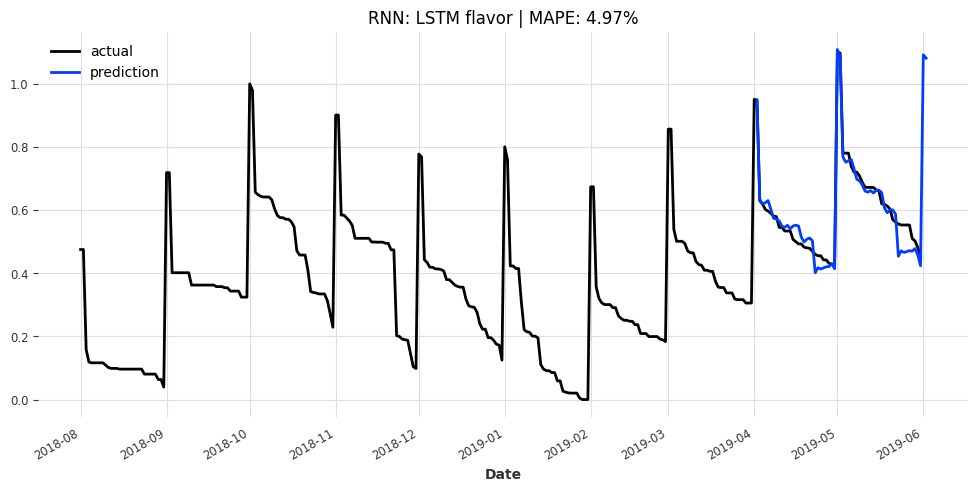

In [9]:
def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

def run_RNN(flavor, ts, train, val):

    # set the model up
    global model_RNN
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    global pred
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

#Setup and run RNN models

# run 3 different flavors of RNN on the time series:
#flavors = ["LSTM", "GRU", "RNN"]
flavors = ['LSTM']

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]


Predicting: 0it [00:00, ?it/s]

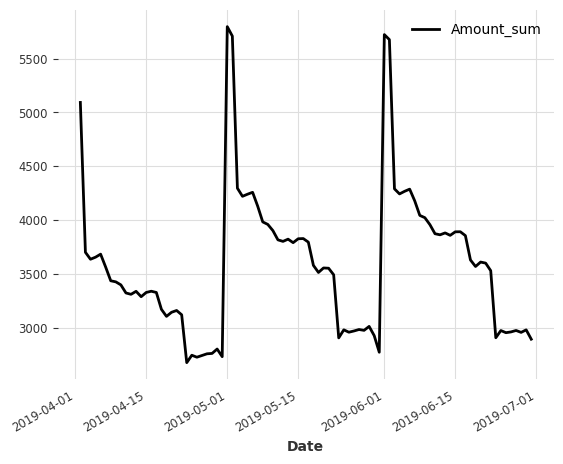

In [12]:
pred1 = trf.inverse_transform(pred)
pred_df = pred1.pd_dataframe()
new_pred=trf.inverse_transform(model_RNN.predict(n=90, future_covariates=covariates))
new_pred.plot()


In [ ]:
expenses

NameError: name 'expenses' is not defined